# Benchmark on OGB, https://ogb.stanford.edu/docs/home/

In [1]:
import importlib
import random
import argparse
import configparser
import numpy as np
import networkx as nx
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_sparse
from torch import Tensor
from torch.nn import Linear
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.optim as optim

from torch_geometric.utils import negative_sampling, to_networkx
from typing import Union, Tuple
from torch_geometric.typing import OptPairTensor, Adj, OptTensor, Size
from torch_sparse import SparseTensor, matmul
from torch_geometric.nn.conv import MessagePassing

from ogb.linkproppred import PygLinkPropPredDataset, Evaluator


import networkx as nx
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

import scipy
import math


from dataset_utils import node_feature_utils
from dataset_utils.node_feature_utils import *
import utils

importlib.reload(utils)

<module 'utils' from '/li_zhengdao/github/GenerativeGNN/utils.py'>

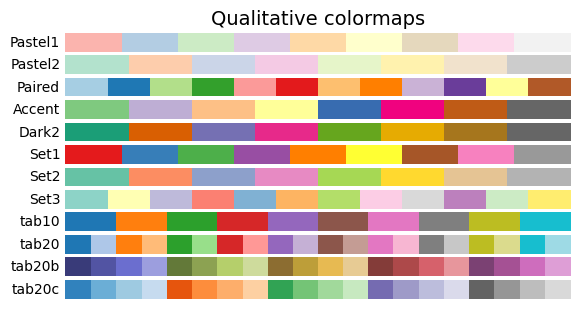

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm


# here..
cmaps = {}

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))


x_y_label_font = 20
x_y_legend_font = 20

plt.rc('font', family='Times New Roman')
fig_dpi = 220
fig_shape_squre = (6, 5)

def plot_color_gradients(category, cmap_list):
    # Create figure and adjust figure height to number of colormaps
    nrows = len(cmap_list)
    figh = 0.35 + 0.15 + (nrows + (nrows - 1) * 0.1) * 0.22
    fig, axs = plt.subplots(nrows=nrows + 1, figsize=(6.4, figh), dpi=100)
    fig.subplots_adjust(top=1 - 0.35 / figh, bottom=0.15 / figh,
                        left=0.2, right=0.99)
    axs[0].set_title(f'{category} colormaps', fontsize=14)

    for ax, name in zip(axs, cmap_list):
        ax.imshow(gradient, aspect='auto', cmap=plt.get_cmap(name))
        ax.text(-0.01, 0.5, name, va='center', ha='right', fontsize=10,
                transform=ax.transAxes)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axs:
        ax.set_axis_off()

    # Save colormap list for later.
    cmaps[category] = cmap_list
    plt.show()

class MyColor(object):
    def __init__(self, cmap_name='tab10', skip_idx=5, backup_name='Set1', backup_color=3):
        self.color_set  = plt.get_cmap(cmap_name).colors
        self.backup_set = plt.get_cmap(backup_name).colors
        self.backup_color = backup_color
        self.skip_idx=skip_idx
        self.idx = 0
        self.color_len = len(self.color_set)
        
    def get_color(self):
        if self.idx == self.color_len - 1:
            self.idx = 0
        if self.idx == self.skip_idx:
            self.idx += 1
            return self.backup_set[self.backup_color]
        color = self.color_set[self.idx]
        self.idx += 1
        return color
    

plot_color_gradients('Qualitative',
                     ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2',
                      'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b',
                      'tab20c'])

# TODO: 0918. For all benchmark datasets.
* check the correlation between degree and CC 
* or $|C_k|$, $k>3$
* Why related to training difficulty? because that GNN cannot learn them.
* Why cannot learn? computational graphs are the same and is bounded by k-WL-test.
* So requires additional information of subgraphs, but $O(kN)$ complexity.
* so sampling may be a good choice.
* may use DP to sample.

* based on above figure, pick same horizontal points
- blueK=0.2, p=0.3, orangeK=0.25, p=0.35, greenK=0.3, p= 0.6,
- redK=0.35,p=0.6, orangek=0.25, p=0.3 (try this first)

# Generate WS graph node feature

# construct node clustring coefficient label

# Generate WS graph dataloader

# CCA (Canical Component Analysis)

# Check whether GNN can learn the CC ?

# generate CC historgram with same degree
# cc without degree correlation bias



# load OGB dataset:

In [22]:
import utils
importlib.reload(utils)

import networkx as nx
from functools import reduce
import models
importlib.reload(models)


def graphs_statistics(adjs:list, labels:list):
    
    statistics = []
    for i, A in enumerate(adjs):
        nx_g = nx.from_numpy_array(A)
        avg_cc = nx.average_clustering(nx_g)
        avg_degree = np.mean(node_feature_utils.node_degree_feature(adj=A)).item()
        tris = np.mean(node_feature_utils.node_tri_cycles_feature(adj=A)).item()
        cycles = nx.cycle_basis(nx_g)
        statistics.append((avg_cc, avg_degree, tris, cycles, labels[i]))
    
    return statistics


def plot_graphs_statistics(title:str, statistics_sorted:list, data_labels:tuple, axe=None, 
                           sort_idx=None, show_idx:list=None):
    
    # NOTE: Sorted by other index
    if sort_idx is not None:
        statistics_sorted = sorted(statistics_sorted, key=lambda x: x[sort_idx])
        
    # TODO: Filter cycles and degree outliers, abs(z-score) > 3.
    statistics_sorted_filtered = []
    for i in statistics_sorted:
        # NOTE: filter any outliers:
        need_filter = False
        for l in range(len(i)):
            if i[l] < -3 or i[l] > 3 or i[l] < -3 or i[l] > 3:
                need_filter = True
                break
        if need_filter:
            continue
        
        statistics_sorted_filtered.append(i)
    
    statistics_sorted = statistics_sorted_filtered
    # TODO: Get correlation:
    corrs = utils.get_corrs(statistics_sorted, cate='all')
    if axe is not None:
        MIC_corr = f"M(dc)={round(corrs['MIC'][1, -2], 2)}, M(dy)={round(corrs['MIC'][1, -1], 2)}," \
                     + f" M(cy)={round(corrs['MIC'][-2, -1], 2)}"
        axe.set_title(title+f"\n C(dc)={round(corrs['pearson'][1, -2], 2)}, C(dy)={round(corrs['pearson'][1, -1], 2)}," \
                     + f" C(cy)={round(corrs['pearson'][-2, -1], 2)}\n{MIC_corr}")
        # NOTE: C: correlation, d:degree, c: cycles, y:labels of samples.
        
        
        colors = MyColor()
        
        from matplotlib import lines
        
        line_styles = list(lines.lineStyles.keys())
        def get_style(next_id):
            return line_styles[next_id%len(line_styles)]
        
        if show_idx is None:
            show_idx = list(range(len(statistics_sorted[0])))
            
        for sid in show_idx:
            # TODO: color?
            axe.plot([i[sid] for i in statistics_sorted], label=data_labels[sid], 
                     linestyle=get_style(sid), color=colors.get_color())
            
    else:
        plt.figure()
        plt.title(title)
        plt.plot([i[0] for i in statistics_sorted], label='avg_cc')
        plt.plot([i[1] for i in statistics_sorted], label='avg_degree',  linestyle='--')
        plt.plot([i[2] for i in statistics_sorted], label='tri_cycles', linestyle='-.')
        plt.plot([i[3] for i in statistics_sorted], label='num_cyclesK=5', linestyle='-.')
        
        plt.legend()
        plt.show()


def plot_cc_degree_distribution(cc_degree_graphs, cc_degree_y, g_label='train'):
    
    # random add edges:
    # add E edges, repeat for 5 times.
    print(type(cc_degree_graphs[0].todense()))

    data_graphs = [(cc_degree_y[i],np.mean(np.sum(cc_degree_graphs[i].todense(), axis=1)), np.mean(node_feature_utils.node_tri_cycles_feature(adj=cc_degree_graphs[i])).item(), i) for i in range(len(cc_degree_graphs))]

    data_graphs_s_train = sorted(data_graphs, key=lambda x: x[0])

    ccs = [d[0] for d in data_graphs_s_train]
    degrees = [d[1]/10 for d in data_graphs_s_train]
    tri_cycles = [d[2]/4 for d in data_graphs_s_train]

    plt.figure()
    plt.title(g_label)
    plt.plot(ccs, label='labels')
    plt.plot(degrees, label='degree',  linestyle='--')
    plt.plot(tri_cycles, label='tri_cycles', linestyle='-.')
    plt.legend()
    plt.show()
    
    

# Try Real-world dataset from PyG generic datasets
website: `https://pytorch-geometric.readthedocs.io/en/latest/notes/data_cheatsheet.html`

* graph classification:
    * TUDataset
    * ZINC

## TODO: 
1. use. # due: 6.30.
2. profile. # due: 7.1.

## TODO (2022.09.24):
* 1. load from gnn-comparison module.
* 2. check the avg.CC avg.Degree and performance associations.

In [4]:
from gnn_comparison.PrepareDatasets import DATASETS

print(DATASETS.keys())

datasets_obj = {}
for k, v in DATASETS.items():
    print('dataset name:', k)
    dat = v()
    datasets_obj[k] = dat
    print(type(dat.dataset.get_data()))


dict_keys(['COLLAB', 'IMDB-BINARY', 'IMDB-MULTI', 'NCI1', 'ENZYMES', 'PROTEINS', 'DD', 'MUTAG', 'CSL'])
dataset name: COLLAB
processed_dir:  DATA/COLLAB/processed
5000
<class 'list'>
dataset name: IMDB-BINARY
processed_dir:  DATA/IMDB-BINARY/processed
1000
<class 'list'>
dataset name: IMDB-MULTI
processed_dir:  DATA/IMDB-MULTI/processed
1500
<class 'list'>
dataset name: NCI1
processed_dir:  DATA/NCI1/processed
4110
<class 'list'>
dataset name: ENZYMES
processed_dir:  DATA/ENZYMES/processed
600
<class 'list'>
dataset name: PROTEINS
processed_dir:  DATA/PROTEINS_full/processed
1113
<class 'list'>
dataset name: DD
processed_dir:  DATA/DD/processed
1178
<class 'list'>
dataset name: MUTAG
processed_dir:  DATA/MUTAG/processed
188
<class 'list'>
dataset name: CSL
processed_dir:  DATA/CSL/processed
600
<class 'list'>


In [5]:
import gnn_comparison
importlib.reload(gnn_comparison)
import gnn_comparison.PrepareDatasets as predata
importlib.reload(predata)

def add_obj(name):
    cls = predata.DATASETS[name]
    dat = cls()
    datasets_obj[name] = dat
    
# add_obj('COLLAB')
# add_obj('NCI1')


In [6]:

def get_pyg_dataset_stats(pyg_data):
    adjs = []
    # TODO: transform into networkx.
    labels = []
    for graph in pyg_data.dataset.get_data():
        row = graph.edge_index[0]
        col = graph.edge_index[1]
        graph.y
        N = graph.x.shape[0]
        dense_A = torch.zeros((N, N))
        dense_A[row, col] = 1
        A = dense_A.detach().numpy()
        adjs.append(A)
        labels.append(graph.y.item())
    return graphs_statistics(adjs, labels)


# print(node_feature_utils.node_cc_avg_feature(adj=dense_A.detach().numpy()))

In [8]:
# TODO: plot on one figure:
datasets_stats = {}
for k, v in datasets_obj.items():
    datasets_stats[k] = get_pyg_dataset_stats(v)

In [9]:
importlib.reload(utils)
import pandas as pd

data_stats = {}
K = 11
tuple_label = ['avg_cc', 'avg_degree', 'tris']
[tuple_label.append(f'cyc<={k}') for k in range(4, K)]
tuple_label.append('y_label')


print('tuple_label:', tuple_label)

normed_stats = {}
for name, st in datasets_stats.items():
    print(f'dataset {name}, len: {len(st)}')    
    stats_tuples = []
    
    for i in range(len(st)):
        cc = st[i][0]
        degree = st[i][1]
        tris= st[i][2]
        y = st[i][-1]
        cycles = st[i][-2]
        
        counter_cur = defaultdict(int)
        for c in cycles:
            if len(c) < K:
                counter_cur[len(c)] += 1
        cycle_num = [0]
        for k in range(3, K):
            if k in counter_cur:
                cycle_num.append(cycle_num[k-3]+counter_cur[k])
            else:
                cycle_num.append(cycle_num[k-3])
                
        cycle_num.pop(0)
        cycle_num = tuple(cycle_num)
        
        stats_tuples.append((cc, degree, tris, *cycle_num, y))
    
    data_array = pd.DataFrame(stats_tuples).values
    # TODO: normalize:
    data_array = utils.normalize(data_array, along_axis=-1)
    
    normed_stats[name] = data_array
    

tuple_label: ['avg_cc', 'avg_degree', 'tris', 'cyc<=4', 'cyc<=5', 'cyc<=6', 'cyc<=7', 'cyc<=8', 'cyc<=9', 'cyc<=10', 'y_label']
dataset COLLAB, len: 5000
normalize along each axis, shape: (5000, 12)
dataset IMDB-BINARY, len: 1000
normalize along each axis, shape: (1000, 12)
dataset IMDB-MULTI, len: 1500
normalize along each axis, shape: (1500, 12)
dataset NCI1, len: 4110
normalize along each axis, shape: (4110, 12)
dataset ENZYMES, len: 600
normalize along each axis, shape: (600, 12)
dataset PROTEINS, len: 1113
normalize along each axis, shape: (1113, 12)
dataset DD, len: 1178
normalize along each axis, shape: (1178, 12)
dataset MUTAG, len: 188
normalize along each axis, shape: (188, 12)
dataset CSL, len: 600
normalize along each axis, shape: (600, 12)


In [23]:
def plot_stats(cur_data_stats:dict, show_idx=None):
    total = len(cur_data_stats.keys())
    nrows = int(total/3) + (0 if total%3 == 0 else 1)
    print('nrows:', nrows, 'total', total)
    
    fig, axes = plt.subplots(nrows, 3, figsize=(10, 8), dpi=300)
    for idx, (name, normed_stat) in enumerate(cur_data_stats.items()):
        plot_graphs_statistics(name, normed_stat, tuple_label, axe=axes[int(idx/3)][idx%3],
                               sort_idx=1, show_idx=show_idx)
    
    if total%3 > 0:
        for d in range(3-total%3):
            fig.delaxes(axes[-1][-d-1])
            
    
    handlers, labels = axes[0][0].get_legend_handles_labels()
    
    fig.legend(handlers, labels, loc='lower center', prop={'size':10})
    plt.tight_layout()
    plt.show()

nrows: 3 total 9


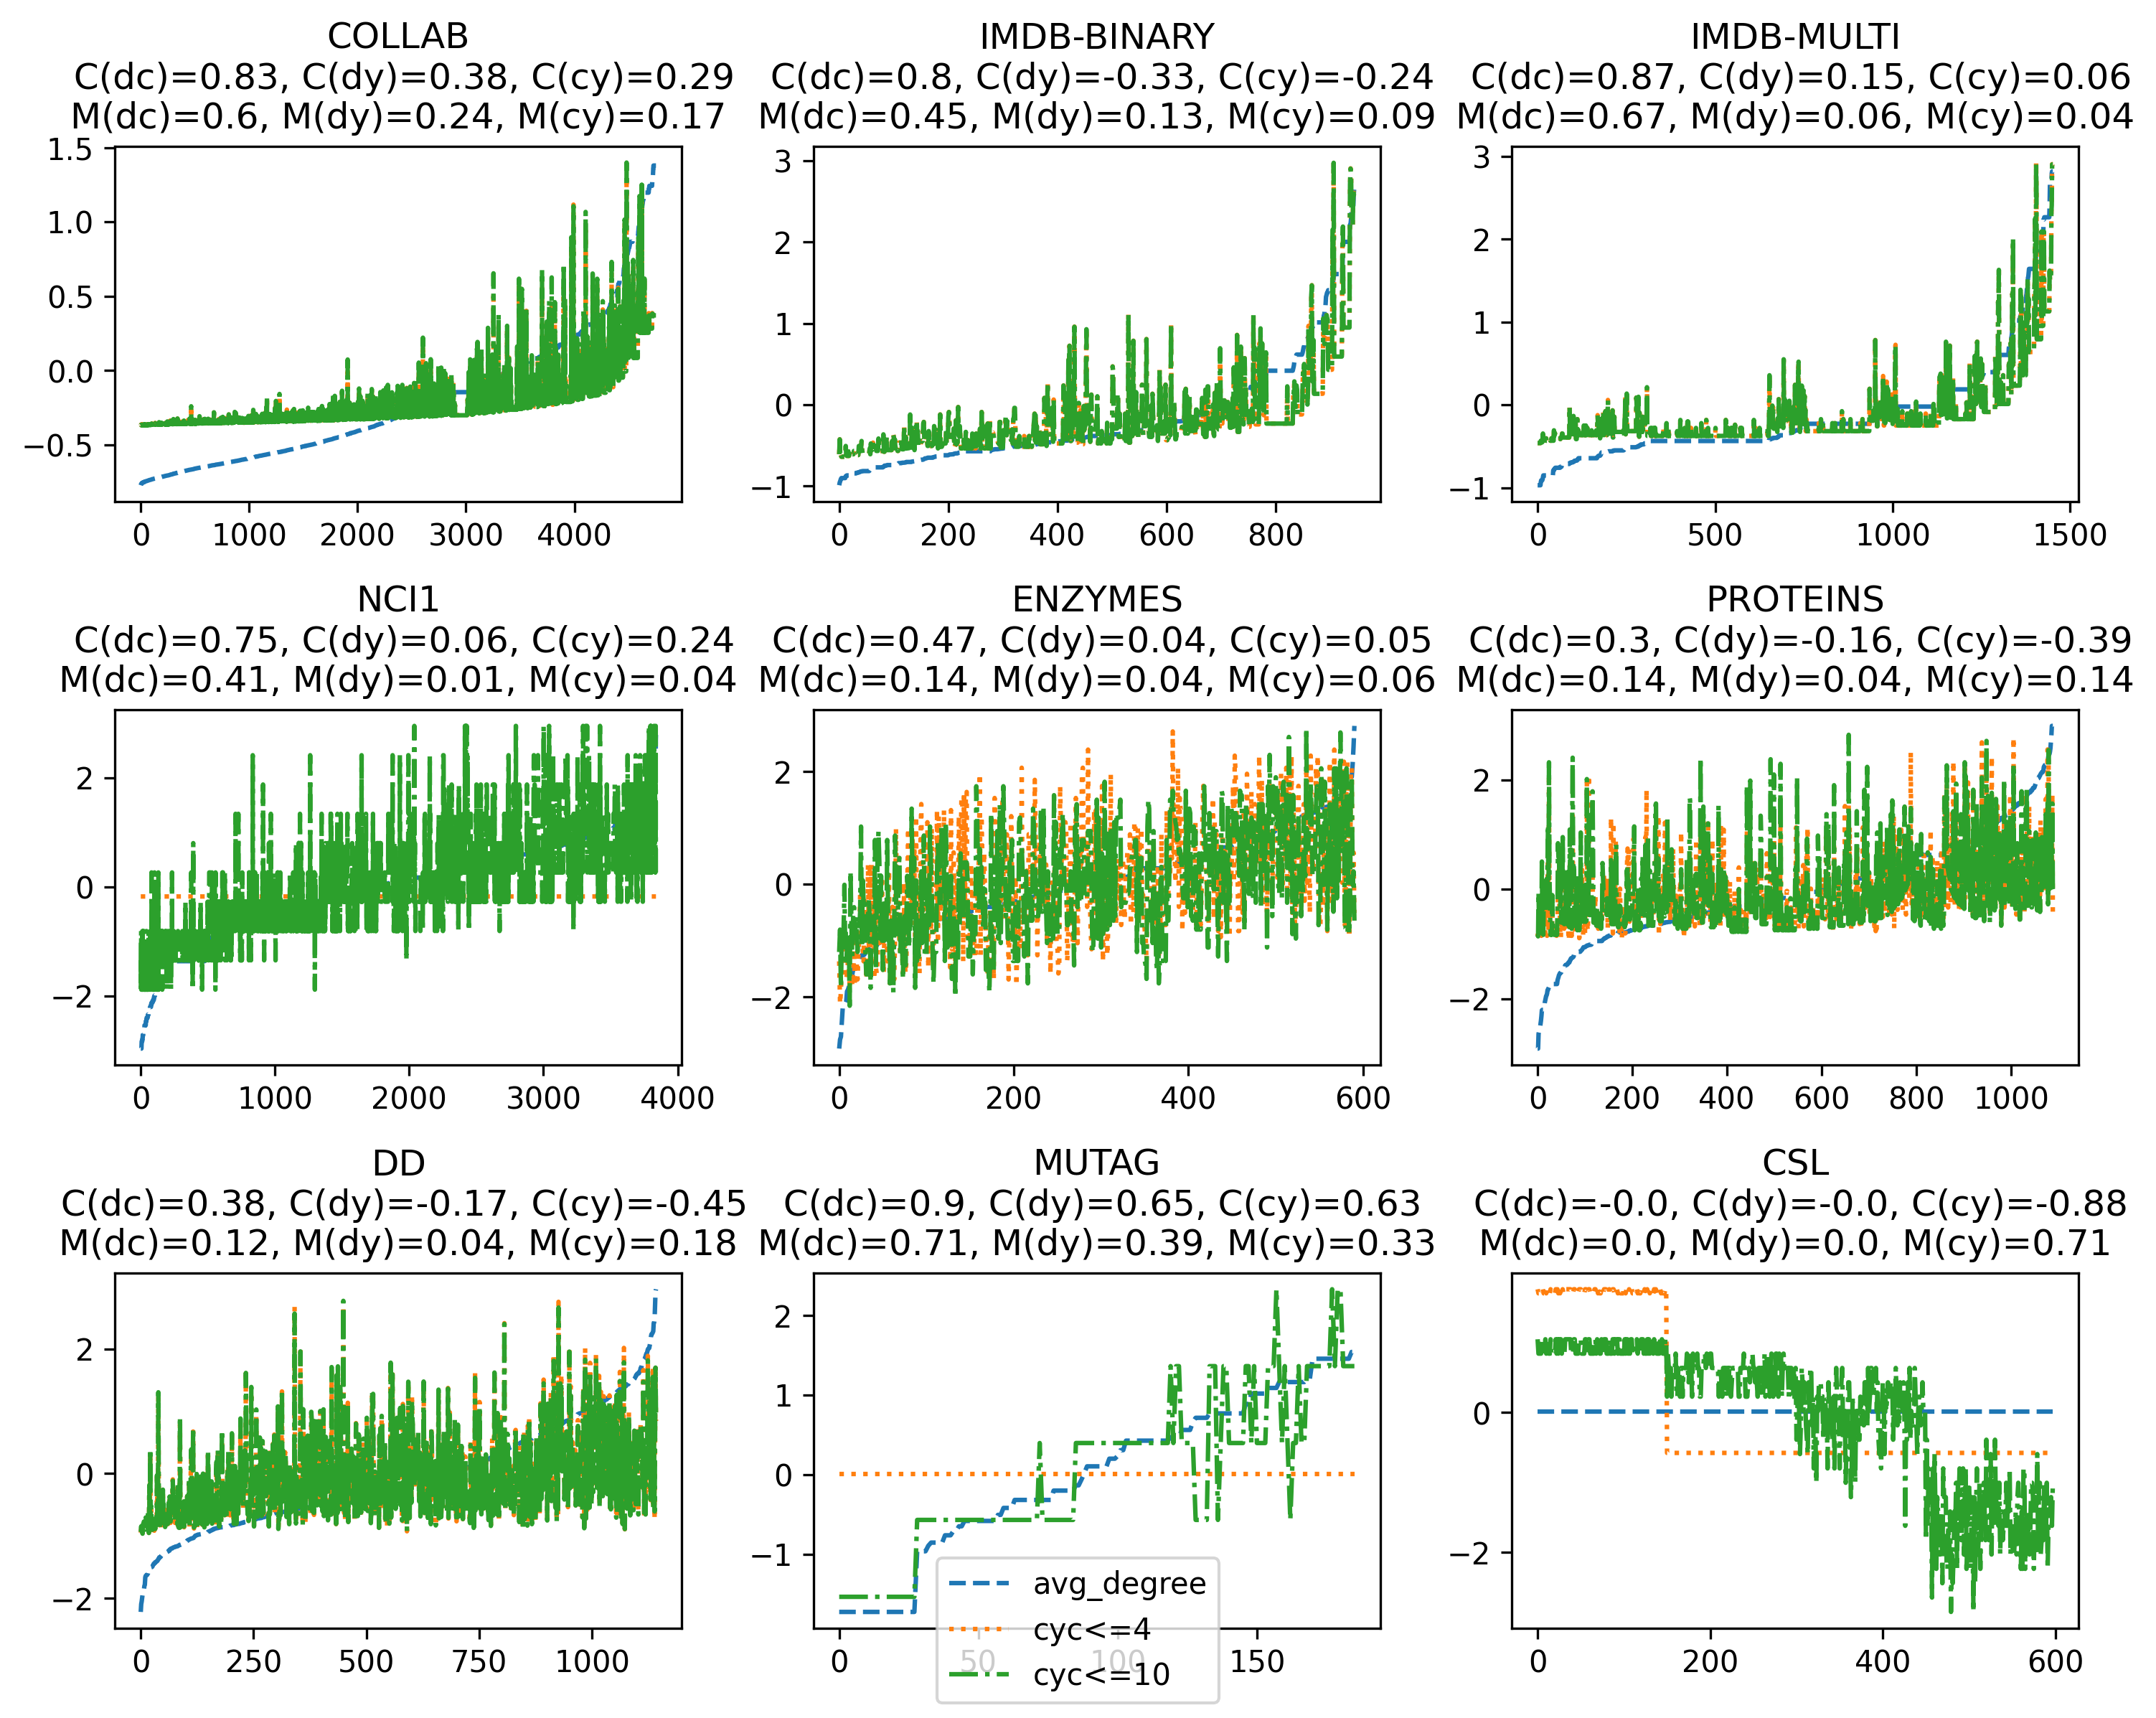

In [24]:
importlib.reload(utils)


plot_stats(normed_stats, show_idx=[1, 3, 9])

In [ ]:
# TODO: correlation of each amount of cycle and degree and label.


